<a href="https://colab.research.google.com/github/RELEBOHILE-PHEKO/CKD_Prediction_API/blob/main/models/Facial_Recognition_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Recognition Preprocessing Summary:
For the face-recognition pipeline, DeepFace (using the FaceNet model) was used to generate facial embeddings from the team’s images. These embeddings translate each face into a numeric feature vector that captures the unique structure of the person’s facial features. After creating the dataset of embeddings and labels, a Random Forest classifier was trained to learn the patterns inside this embedding space and distinguish between the registered users. When a new image is processed, its embedding is fed into the classifier, which predicts the most likely identity based on what it learned during training.

In [16]:
#  Install dependencies
!pip install opencv-python matplotlib pandas numpy
!pip install deepface



# Clone the  GitHub repo
!git clone https://github.com/Pam-Pam29/Formative-2-Multimodal-Data-Preprocessing.git
%cd Formative-2-Multimodal-Data-Preprocessing/data/images
!ls


Cloning into 'Formative-2-Multimodal-Data-Preprocessing'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 153 (delta 50), reused 42 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (153/153), 12.36 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Formative-2-Multimodal-Data-Preprocessing/data/images/Formative-2-Multimodal-Data-Preprocessing/data/images
neutral.jpg	  smiling.jpg	    Suprised-Pam_.jpg
Neutral-Pam.jpg   Smiling-Pam.jpg   surprised.jpg
neutral-Rele.jpg  smiling-Rele.jpg  surprised-Rele.jpg


In [12]:
#Import librabries
from deepface import DeepFace
import cv2
import os
import shutil
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize

#

# ARGUMENTATION AND EXTRACTION

In [ ]:
# Full Pipeline: Augmentation + Feature Extraction

import os
import cv2
import pandas as pd
from deepface import DeepFace

original_folder = "."
augmented_folder = "./augmented"
os.makedirs(augmented_folder, exist_ok=True)

print("Starting image augmentation...")

# 1. Image Augmentation
for filename in os.listdir(original_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(original_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(os.path.join(augmented_folder, "rotated_" + filename), rotated)
        flipped = cv2.flip(img, 1)
        cv2.imwrite(os.path.join(augmented_folder, "flipped_" + filename), flipped)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(augmented_folder, "gray_" + filename), gray)

print("Augmentation complete. Extracting embeddings...")

# 2. Embedding Extraction
embeddings = []
names = []
folders = [original_folder, augmented_folder]

for folder in folders:
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            path = os.path.join(folder, filename)
            try:
                embedding = DeepFace.represent(
                    img_path=path,
                    model_name="Facenet",
                    detector_backend="opencv",
                    enforce_detection=False
                )[0]["embedding"]
                embeddings.append(embedding)
                if "Rele" in filename:
                    names.append("Relebohile")
                elif "Pam" in filename:
                    names.append("Victoria")
                else:
                    names.append("Denis")
                print("Processed:", path)
            except Exception as e:
                print("Could not process:", path, "Error:", e)

df = pd.DataFrame(embeddings)
df["name"] = names
df.to_csv("image_features.csv", index=False)

print("Finished. Saved image_features.csv with", len(df), "samples.")


Starting image augmentation...
Augmentation complete. Extracting embeddings...
25-11-14 14:08:59 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 160MB/s]


Processed: ./smiling.jpg
Processed: ./neutral-Rele.jpg
Processed: ./Suprised-Pam_.jpg
Processed: ./Smiling-Pam.jpg
Processed: ./neutral.jpg
Processed: ./Neutral-Pam.jpg
Processed: ./surprised-Rele.jpg
Processed: ./smiling-Rele.jpg
Processed: ./surprised.jpg
Processed: ./augmented/flipped_Smiling-Pam.jpg
Processed: ./augmented/rotated_Neutral-Pam.jpg
Processed: ./augmented/rotated_smiling-Rele.jpg
Processed: ./augmented/flipped_Neutral-Pam.jpg
Processed: ./augmented/gray_Neutral-Pam.jpg
Processed: ./augmented/gray_smiling.jpg
Processed: ./augmented/gray_surprised.jpg
Processed: ./augmented/rotated_smiling.jpg
Processed: ./augmented/rotated_neutral.jpg
Processed: ./augmented/flipped_smiling-Rele.jpg
Processed: ./augmented/gray_neutral.jpg
Processed: ./augmented/gray_surprised-Rele.jpg
Processed: ./augmented/gray_smiling-Rele.jpg
Processed: ./augmented/rotated_surprised.jpg
Processed: ./augmented/gray_neutral-Rele.jpg
Processed: ./augmented/flipped_neutral.jpg
Processed: ./augmented/flipp

In [ ]:
ls

augmented/          Neutral-Pam.jpg   Smiling-Pam.jpg    surprised.jpg
image_features.csv  neutral-Rele.jpg  smiling-Rele.jpg   surprised-Rele.jpg
neutral.jpg         smiling.jpg       Suprised-Pam_.jpg


# Add a Classifier (Model Implementation + Evaluation)

Training samples: 25, Test samples: 11

Random Forest Accuracy: 100.00%
F1-Score (weighted): 1.0000

Classification Report:
               precision    recall  f1-score   support

       Denis       1.00      1.00      1.00         3
  Relebohile       1.00      1.00      1.00         4
    Victoria       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



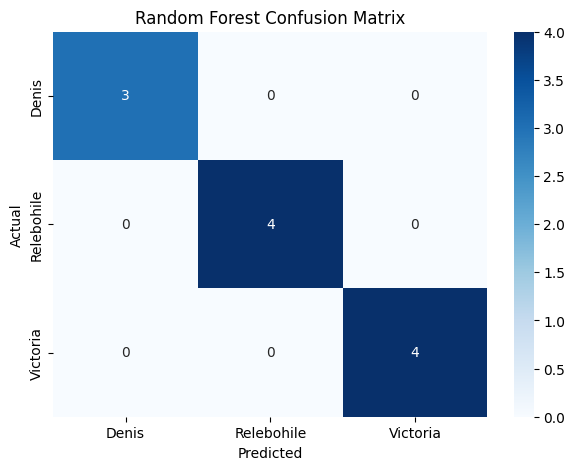

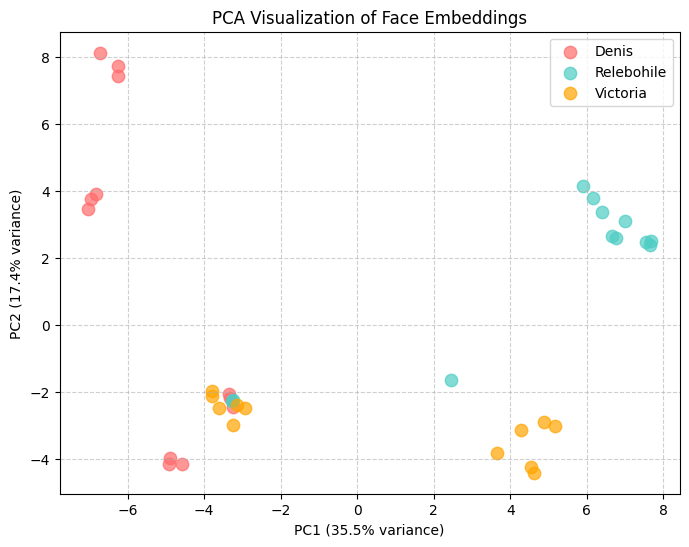

In [8]:
# Random Forest Classifier

# Load embeddings from dataframe
X = df.drop(columns=["name"])
y = df["name"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Accuracy & Classification Report
acc = accuracy_score(y_test, y_pred)
print(f"\nRandom Forest Accuracy: {acc*100:.2f}%")

# Calculate F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score (weighted): {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('facial_recognition_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# PCA 2D visualization of embeddings
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
colors = ["#FF6B6B", "#4ECDC4", "#FFA500"]
for i, name in enumerate(sorted(y.unique())):
    mask = y == name
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=name, alpha=0.7, s=80, color=colors[i])
plt.title("PCA Visualization of Face Embeddings")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig('pca_face_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

# SIMULATE ON ANAUTHORISED/UNKNOWN FACE

In [11]:

# Simulate on an unknown face

print("\n" + "="*60)
print("UNAUTHORIZED ACCESS TEST")
print("="*60)

unauthorized_image = "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=400"

try:
    # Extract embedding
    unauth_embedding = DeepFace.represent(
        img_path=unauthorized_image,
        model_name="Facenet",
        detector_backend="opencv",
        enforce_detection=False
    )[0]["embedding"]

    # Compare to known embeddings
    similarities = cosine_similarity([unauth_embedding], X)[0]
    best_match_index = np.argmax(similarities)
    confidence = similarities[best_match_index] * 100

    print("\nUnauthorized Face Test Results:")
    print(f"  Best Match: {y.iloc[best_match_index]}")
    print(f"  Confidence: {confidence:.2f}%")
    print("  Threshold: 50%")

    # Decision
    if confidence < 50:
        print("\n✓ Status: UNAUTHORIZED - ACCESS DENIED")
        print("  Reason: Confidence below threshold")
    else:
        print("\n✗ Status: INCORRECTLY AUTHORIZED")
        print(f"  Closest match: {y.iloc[best_match_index]} ({confidence:.2f}%)")

except Exception as e:
    print(f"Error processing unauthorized image: {e}")

print("="*60)



UNAUTHORIZED ACCESS TEST

Unauthorized Face Test Results:
  Best Match: Relebohile
  Confidence: 23.86%
  Threshold: 50%

✓ Status: UNAUTHORIZED - ACCESS DENIED
  Reason: Confidence below threshold


# Face Recognition Test + Visualization (multi-face version)


Testing: Smiling-Pam.jpg
✓ AUTHORIZED: Denis (63.65% confidence)


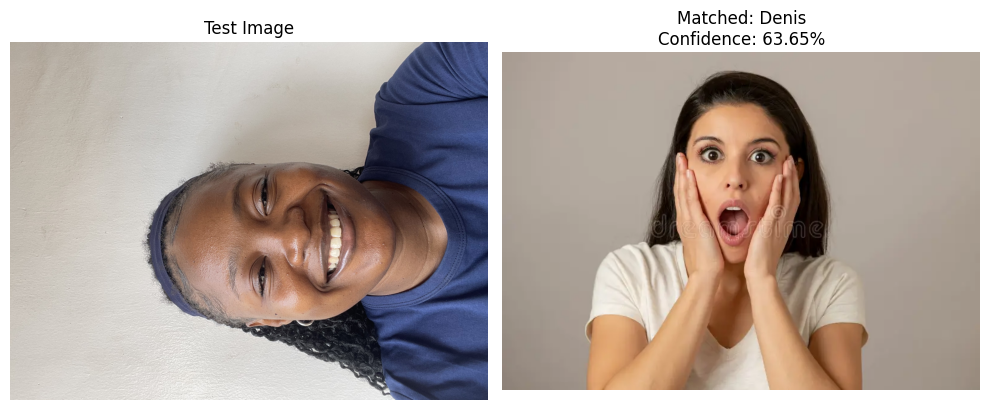


Testing: surprised.jpg
✓ AUTHORIZED: Denis (100.00% confidence)


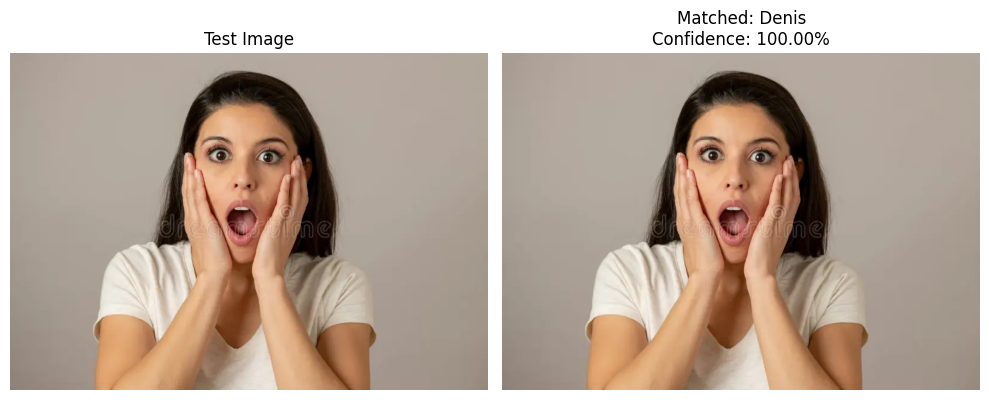


Testing: neutral-Rele.jpg
✓ AUTHORIZED: Relebohile (100.00% confidence)


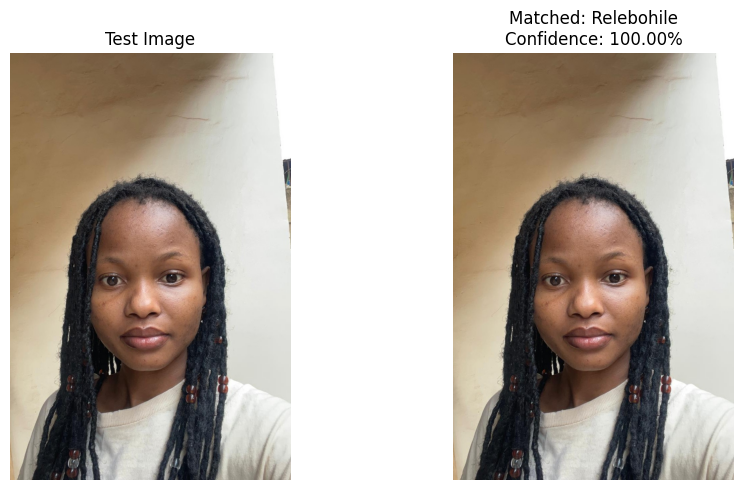

In [9]:
# Face Recognition Test + Visualization

# Load embeddings
df = pd.read_csv("image_features.csv")
X = df.drop(columns=["name"])
y = df["name"]

# Map names to example image
name_to_file = {
    "Relebohile": "neutral-Rele.jpg",
    "Victoria": "Smiling-Pam.jpg",
    "Denis": "surprised.jpg"
}

# Test images
test_images = ["Smiling-Pam.jpg", "surprised.jpg", "neutral-Rele.jpg"]

# Recognition function
def recognize_face_rf(image_path, model, X, y, threshold=0.5):
    embedding = DeepFace.represent(
        img_path=image_path,
        model_name="Facenet",
        detector_backend="opencv",
        enforce_detection=False
    )[0]["embedding"]
    pred_name = model.predict([embedding])[0]
    class_embeddings = X[y==pred_name]
    confidence = max(cosine_similarity([embedding], class_embeddings)[0])
    authorized = confidence >= threshold
    return pred_name, confidence*100, authorized

# Test each image
for test_image in test_images:
    pred_name, confidence, authorized = recognize_face_rf(test_image, rf_model, X, y)
    print(f"\nTesting: {test_image}")
    if authorized:
        print(f"✓ AUTHORIZED: {pred_name} ({confidence:.2f}% confidence)")
    else:
        print(f"✗ UNAUTHORIZED / Low confidence ({confidence:.2f}%)")

    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].imshow(mpimg.imread(test_image))
    axes[0].set_title("Test Image")
    axes[0].axis("off")

    if authorized and pred_name in name_to_file:
        axes[1].imshow(mpimg.imread(name_to_file[pred_name]))
        axes[1].set_title(f"Matched: {pred_name}\nConfidence: {confidence:.2f}%")
    else:
        axes[1].text(0.5, 0.5, "Access Denied\nUnauthorized", ha="center", va="center", fontsize=16, color='red')
        axes[1].set_title("No Match")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

In [14]:
!ls /content


Formative-2-Multimodal-Data-Preprocessing  sample_data	YOUR_REPO
